## The task

We need to predict the number of taxi orders for the next hour.


The value of the * RMSE * metric on the test sample should be no more than 48.


# 1. Start

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [2]:
data=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
#make sure the dates are in chronological order
if not data.index.is_monotonic:
    data = data.sort_index(inplace=True)

print(data.index.is_monotonic)    

True


In [4]:
#the time series interval will be 1 hour
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
data.head(10)   

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [6]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


In [7]:
data.isna().sum()

num_orders    0
dtype: int64

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> 
The dataset with information on taxi orders from March 2018 to August 2018 (inclusive) with one column and 4416 rows. The dates are in chronological order. There are no missing values</div>

# 2. Analysis

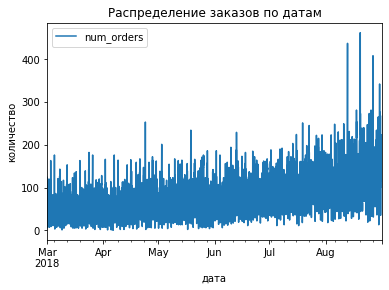

In [8]:
#let's look at the distribution of orders across the entire dataset
data.plot()
plt.xlabel('data')
plt.ylabel('quantity')
plt.title('Distribution of orders by dates')
plt.show();

In [9]:
#select the first month and take a closer look
data_month_start = data.head(24*31)

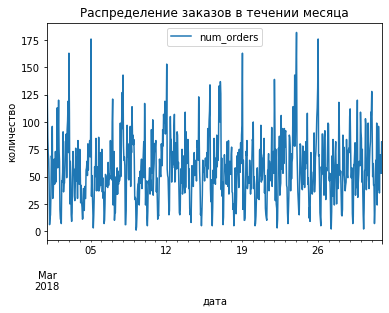

In [10]:
def month(df):
    df.head(24*31).plot()
    plt.xlabel('data')
    plt.ylabel('quantity')
    plt.title('Distribution of orders throughout the month')
    plt.show();
    
month(data_month_start)    

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b>During the month there are days with a very large number of orders</div>

In [11]:
#let's see which days of the week the most orders
data_week_start = data.head(24*7)

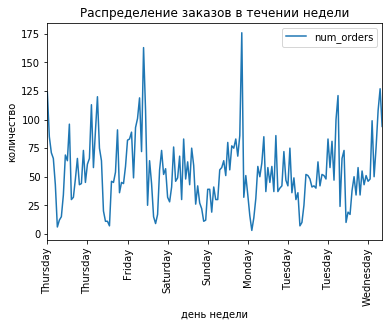

In [12]:
def week(df):
    df = df.reset_index()
    df['weekDay']=df['datetime'].dt.day_name()
    df.plot('weekDay', 'num_orders')
    plt.xticks(rotation=90)
    plt.xlabel('day of the week')
    plt.ylabel('quantity')
    plt.title('Distribution of orders during the week');
    
week(data_week_start)    

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> 
The graph shows that the largest number of taxi orders is on Sunday evening and Friday evening, which is logical. Least Monday morning.</div>

In [13]:
#also examine the last month of the dataset
data_month_last = data.tail(24*31)

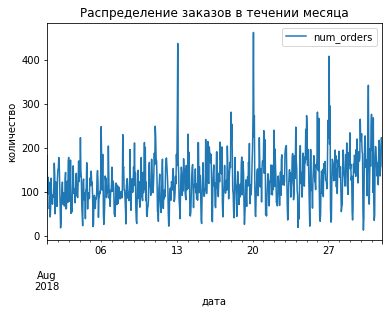

In [14]:
month(data_month_last)

In [15]:
data_week_last = data.tail(24*7)  

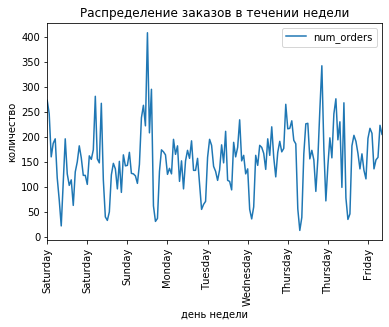

In [16]:
week(data_week_last)

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> Looking at the last month of summer, you can see that the largest number of orders to the airport remained on Sunday evening, but the minimum moved to Thursday morning.</div>

In [17]:
#Let's look at the number of orders in spring and summer
print('------Spring-------')
print()
print(data.head(24*92).describe())

------Весна-------

        num_orders
count  2208.000000
mean     65.003170
std      32.899422
min       0.000000
25%      43.000000
50%      62.000000
75%      83.000000
max     253.000000


In [18]:
print('------Summer-----')
print()
print(data.tail(24*92).describe())

------Лето-----

        num_orders
count  2208.000000
mean    103.842391
std      47.098376
min       6.000000
25%      73.000000
50%      98.000000
75%     127.000000
max     462.000000


In [19]:
#Let's look at the number of orders at the beginning and at the end of the dataset
print('------March-------')
print()
print(data_month_start.describe())

------Март-------

       num_orders
count  744.000000
mean    57.483871
std     29.562439
min      1.000000
25%     39.000000
50%     55.000000
75%     75.000000
max    182.000000


In [20]:
print('------August-------')
print()
print(data_month_last.describe())

------Август-------

       num_orders
count  744.000000
mean   127.651882
std     56.242228
min     13.000000
25%     91.000000
50%    122.000000
75%    160.000000
max    462.000000


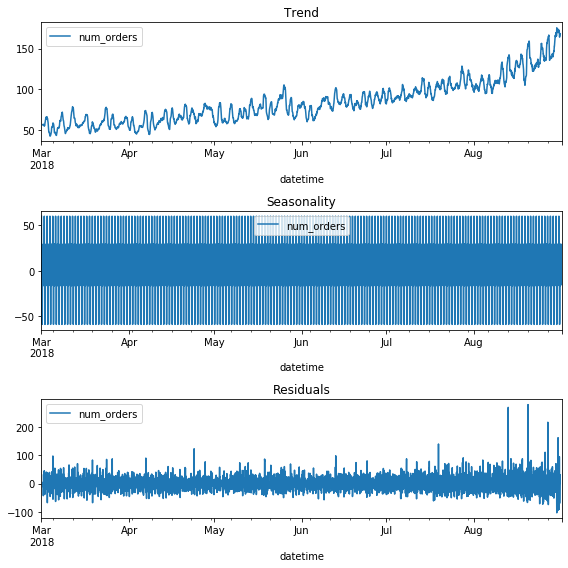

In [21]:
#Let us decompose the time series into a trend and a seasonal component
decomposed = seasonal_decompose(data)
plt.figure(figsize=(8,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

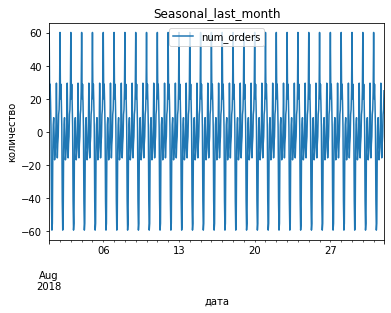

In [22]:
#let's take a closer look at the "seasonality" chart in August 
decomposed.seasonal.tail(24*31).plot(title='Seasonal_last_month')
plt.xlabel('data')
plt.ylabel('quantity');

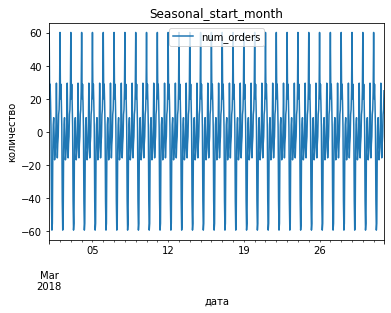

In [23]:
#let's take a closer look at the "seasonality" chart in March
decomposed.seasonal.head(24*31).plot(title='Seasonal_start_month')
plt.xlabel('data')
plt.ylabel('quantity');

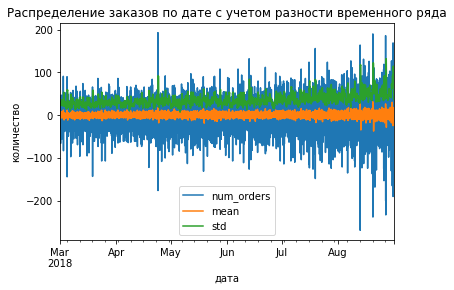

In [24]:
#plot the moving average and moving standard deviation
data_shift=data - data.shift()
data_shift['mean']=data_shift['num_orders'].rolling(10).mean()
data_shift['std']=data_shift['num_orders'].rolling(10).std()
data_shift.plot()
plt.xlabel('data')
plt.ylabel('quantity')
plt.title('Distribution of orders by date, taking into account the difference in the time series')
plt.show();

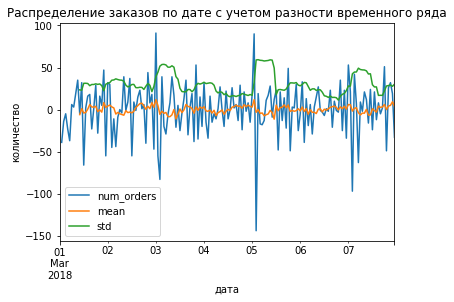

In [25]:
#more details can be seen on the example of the first week
data_week_start= data_week_start - data_week_start.shift()
data_week_start['mean']=data_week_start['num_orders'].rolling(10).mean()
data_week_start['std']=data_week_start['num_orders'].rolling(10).std()
data_week_start.plot()
plt.xlabel('data')
plt.ylabel('quantity')
plt.title('Distribution of orders by date, taking into account the difference in the time series')
plt.show();

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b>Having considered the data in detail, we can say that the total number of orders at the beginning of the dataset and at the end does not change, and this clearly shows - SEASONALITY - i.e. there is no seasonality for taxi orders to the airport. On the graph we see a stationary stochastic process. As for the trend, it can be seen that, again, the total number of orders in March and August is the same, but their maximum per day is very different (March max = 182 orders, August - max 462 orders per day.)</div>

In [26]:
#a more stationary series is easier to predict, but we will work with the original dataset.
# make sure that the initial data has not changed during the period of our analysis
data  

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 3. Model

In [27]:
#Let's set the reference value for the test sample. 
#After training the model, the value of the metric should be less than the benchmark

#divide the dataset into 3 samples. We will make the size of the test sample 10% (condition of the problem)
train, valid_test = train_test_split(data, shuffle = False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle = False, test_size=0.5)
print('Train sample')
print(train.index.min(), train.index.max())
print('Valid sample')
print(valid.index.min(), valid.index.max())
print('Test sample')
print(test.index.min(), test.index.max())

Обучающая выборка
2018-03-01 00:00:00 2018-07-26 03:00:00
Валидационная выборка
2018-07-26 04:00:00 2018-08-13 13:00:00
Тестовая выборка
2018-08-13 14:00:00 2018-08-31 23:00:00


In [28]:
#Let's measure the quality of prediction of time series without training, 
#using the model's estimate of the previous value of the series.
pred_previous = test.shift()
pred_previous.iloc[0]=train.iloc[-1]
rmse_not_fit = mean_squared_error(test['num_orders'], pred_previous)**0.5

print('RMSE without training:',rmse_not_fit)

RMSE без обучения: 58.88016052260236


In [29]:
#Let's create features
def make_features(data, max_lag, rolling_mean_size):
    data['year']=data.index.year
    #data['month']=data.index.month
    #data['day']=data.index.day
    data['dayofweek']=data.index.dayofweek
    data['hour']=data.index.hour
    
    for lag in range(1, max_lag +1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(data, 168, 10)

print(data.head(3))

                     num_orders  year  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-01 00:00:00         124  2018          3     0    NaN    NaN    NaN   
2018-03-01 01:00:00          85  2018          3     1  124.0    NaN    NaN   
2018-03-01 02:00:00          71  2018          3     2   85.0  124.0    NaN   

                     lag_4  lag_5  lag_6  ...  lag_160  lag_161  lag_162  \
datetime                                  ...                              
2018-03-01 00:00:00    NaN    NaN    NaN  ...      NaN      NaN      NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...      NaN      NaN      NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...      NaN      NaN      NaN   

                     lag_163  lag_164  lag_165  lag_166  lag_167  lag_168  \
datetime                                                                    
2018-03-01 00:00:00      NaN      NaN      NaN      NaN      NaN     

In [30]:
#divide the dataset with features into samples
train, valid_test = train_test_split(data, shuffle = False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle = False, test_size=0.5)
print('Train sample')
print(train.index.min(), train.index.max())
print('Valid sample')
print(valid.index.min(), valid.index.max())
print('Test sample')
print(test.index.min(), test.index.max())

Обучающая выборка
2018-03-01 00:00:00 2018-07-26 03:00:00
Валидационная выборка
2018-07-26 04:00:00 2018-08-13 13:00:00
Тестовая выборка
2018-08-13 14:00:00 2018-08-31 23:00:00


In [31]:
#remove gaps
train=train.dropna()

In [32]:
#select the target feature and features (the year is the same everywhere - remove this column)
target_train=train['num_orders']
features_train = train.drop(['num_orders', 'year'], axis=1)

target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders', 'year'], axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders', 'year'], axis=1)

print('Train sample')
print(target_train.shape, features_train.shape)
print('Valid sample')
print(target_valid.shape, features_valid.shape)
print('Test sample')
print(target_test.shape, features_test.shape)

Обучающая выборка
(3364,) (3364, 171)
Валидационная выборка
(442,) (442, 171)
Тестовая выборка
(442,) (442, 171)


In [33]:
#combine train and valid samples
merge_features = pd.concat([features_train, features_valid])
merge_target = pd.concat([target_train, target_valid])

In [34]:
%%time

#model DecisionTreeRegressor
model_tree=DecisionTreeRegressor(random_state=90, max_depth=6)
model_tree.fit(merge_features, merge_target)
predictions_valid=model_tree.predict(features_valid)
result_tree=(mean_squared_error(target_valid, predictions_valid))**0.5

print('RMSE:', result_tree)  

RMSE: 23.540432103906763
CPU times: user 245 ms, sys: 0 ns, total: 245 ms
Wall time: 283 ms


In [35]:
%%time

#model RandomForestRegressor
best_result=10000
best_depth=0
best_est = 0
for est in range(10,60,10):
    for depth in range (1,6):
        model_forest=RandomForestRegressor(random_state=90, n_estimators = est, max_depth = depth)
        model_forest.fit(merge_features, merge_target)
        predictions_valid=model_forest.predict(features_valid)
        result_forest=(mean_squared_error(target_valid, predictions_valid))**0.5
        if result_forest<best_result:
            best_result=result_forest
            best_depth=depth
            best_est=est
            
print('RMSE:', result_forest, best_depth, best_est)  

RMSE: 23.714650975775978 5 40
CPU times: user 58.8 s, sys: 54.4 ms, total: 58.8 s
Wall time: 59.5 s


In [36]:
%%time

#model LinearRegression
model_linear=LinearRegression(normalize=True)
model_linear.fit(merge_features, merge_target)
predictions_valid = model_linear.predict(features_valid)
result_linear=(mean_squared_error(target_valid, predictions_valid))**0.5

print('RMSE:', result_linear)  

RMSE: 26.623579308264844
CPU times: user 210 ms, sys: 205 ms, total: 415 ms
Wall time: 363 ms


In [37]:
#model LGBMRegressor
#cv = KFold(n_splits=3, shuffle=False)

tscv = TimeSeriesSplit(n_splits = 10)
#for train, test in tscv.split(features_train):
    #print(train, test)

model_lgb = LGBMRegressor(boosting_type='gbdt', verbose=1, force_col_wise=True, random_state = 90)

params = {
    'learning_rate': [0.08, 0.1, 0.12],
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41]
}

grid_model_lgb = GridSearchCV(model_lgb,
                        params,
                        cv=tscv,
                        scoring='neg_mean_squared_error',
                        verbose=1,
                        n_jobs=1)

In [38]:
%%time
grid_model_lgb.fit(merge_features, merge_target)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.4min finished


CPU times: user 7min 19s, sys: 3.08 s, total: 7min 22s
Wall time: 7min 28s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, force_col_wise=True,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_...
                                     objective=None, random_state=90,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0, verbose=1),
             iid='warn', n_jobs=1,
             param_grid={'learning_rate': [0.08, 0.1, 0.12],
                         'n_

In [39]:
grid_model_lgb.best_params_

{'learning_rate': 0.08, 'n_estimators': 60, 'num_leaves': 21}

In [40]:
%%time

model_lgb = LGBMRegressor(
    n_estimators=60, num_leaves=21, learning_rate=0.08, random_state=90)
model_lgb.fit(merge_features, merge_target, verbose=False)
predictions_valid = model_lgb.predict(features_valid)
result_lgb = mean_squared_error(target_valid,predictions_valid) ** 0.5
print('RMSE:',result_lgb)

RMSE: 17.560869269291622
CPU times: user 3.01 s, sys: 33 ms, total: 3.04 s
Wall time: 3.09 s


In [41]:
#we will summarize the results of the models in one table
results = [
    [result_tree],
    [result_forest],
    [result_linear],
    [result_lgb],
    [rmse_not_fit]
];
pd.DataFrame(data = results,
             index=['TreeRegressor', 'ForestRegressor', 'linearRegressor', 'LightGBM', 'not_fit'],
             columns=['rmse'])

,rmse
TreeRegressor,23.540432
ForestRegressor,23.714651
linearRegressor,26.623579
LightGBM,17.560869
not_fit,58.880161


<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> We set a benchmark for the rmse metric of the test sample, We built 4 different models and selected the best hyperparameters. The LightGBM model showed the best metric value. </div>

# 4. Test

In [42]:
#check the best model on a test set
model_test = LGBMRegressor(
    n_estimators=60, num_leaves=21, learning_rate=0.08, random_state=90)
model_test.fit(merge_features, merge_target, verbose=False)
predictions_test = model_test.predict(features_test)
result_test = mean_squared_error(target_test,predictions_test) ** 0.5
print('RMSE:',result_test)

RMSE: 36.63550664938313


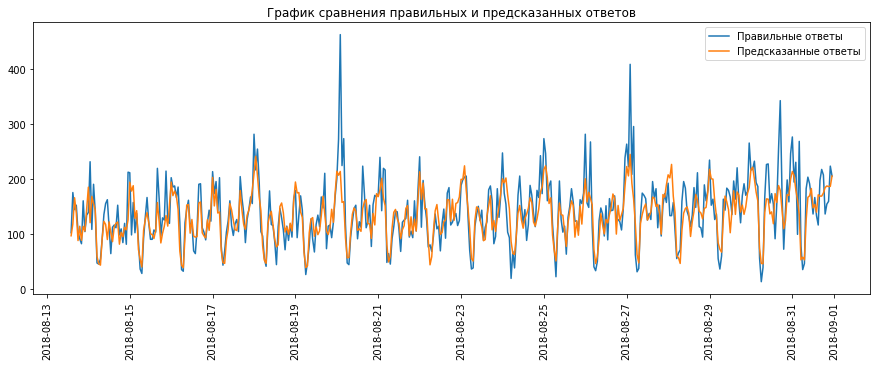

In [43]:
#visualize correct answers and predicted
plt.figure(figsize=(15, 5))
plt.plot(target_test, label='Correct answers')
plt.plot(target_test.index, predictions_test, label='Predicted Answers')
plt.legend()
plt.title('Graph comparing correct and predicted answers')
plt.xticks(rotation=90);

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>General conclusion:</b> Changing the number of lagging values ​​and window width, we achieved the RMSE value on the test sample of the best LGBMRegressor model - 37. That satisfies the condition of the problem (less than 48). Also, the value on the test sample after training the model is less than the RMSE metric on the test sample for the model without training. If the number of lagging values ​​and the window width are set to 1 and 1, respectively, then the value RMSE_test = 41.99532076313603. Therefore, I experimented with values ​​for a long time to minimize the metric. Visualized the correct answers and the predicted ones.</div>